In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

MEMORY = 8*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

2023-02-14 16:02:30.662024: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-14 16:02:30.854625: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-14 16:02:31.478942: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /end/home/rh2310/lib:/end/soft/Linux_2.6_64/lib::/end/home/rh2310/.conda/envs/tensorflo

1 Physical GPUs, 1 Logical GPUs


In [2]:
from local_utils import *

# Note to remember
# In this form of reshaping the datasets, u, u_xx, u_yy, u_t, v, v_xx and v_yy, v_t must be transposed to correctly show x and y coordinates

# This note book use only one snapshot (the last), does not estimate the time derivatives and use the exact u and v to reduce the loss residual. FInaly, the parameters are constant.

In [3]:
sim_name = "Koch_Meinhardt_2"
x_slice=slice(0,100,1)#slice(30,65,1)#slice(0,100,1)#slice(30,65,1)#slice(50,65,1)#
y_slice=slice(0,100,1)#slice(50,85,1)#slice(0,100,1)#slice(50,85,1)#slice(70,85,1)#
pattern = load(sim_name, x_slice, y_slice,
               data_time_start=-3,
               data_time_len=2,
               data_time_step=1)

x_range = np.linspace(0, 1, pattern.simulation.n[0])*pattern.simulation.L[0]
y_range = np.linspace(0, 1, pattern.simulation.n[0])*pattern.simulation.L[1]
x_range = x_range[x_slice]
y_range = y_range[y_slice]

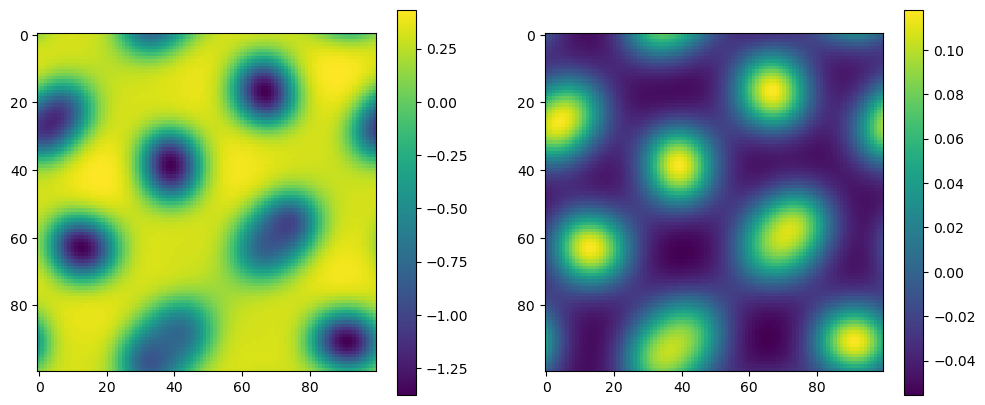

In [4]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(pattern.params["D_u"]*(pattern.c_xx[0,:, : , -1] + pattern.c_yy[0,:, : , -1]) - pattern.c_t[0,:, : , -1])
plt.colorbar()
plt.subplot(122)
plt.imshow(pattern.params["D_v"]*(pattern.c_xx[1,:, : , -1] + pattern.c_yy[1,:, : , -1]) - pattern.c_t[1,:, : , -1])
plt.colorbar()

In [5]:
x = tf.constant(x_range, dtype=tf.float32)
y = tf.constant(y_range, dtype=tf.float32)
# The order of the Y and X must be reversed,
# since the chnages the value finds the derivatives
#Y, X = tf.meshgrid(x, y)
X, Y = tf.meshgrid(x, y)
ts = tf.constant(pattern.t_star[-1:], dtype=tf.float32)
T = ts[tf.newaxis, tf.newaxis, :] * tf.ones(X.shape)[:, :, tf.newaxis]
H = tf.concat(
            [
                tf.concat(
                    [
                        X[tf.newaxis, :, :, tf.newaxis],
                        Y[tf.newaxis, :, :, tf.newaxis],
                        T[:, :, i : i + 1][tf.newaxis, :, :, :],
                    ],
                    axis=3,
                )
                for i in range(T.shape[-1])
            ],
            axis=0,
        )

In [6]:
H.shape

TensorShape([1, 100, 100, 3])

In [7]:
def grads(pinn, inputs):
    
    with tf.GradientTape(persistent=True) as tape:        
        tape.watch(inputs)      
        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(inputs)            
            outputs = pinn.net(inputs)            
        
            u = tf.squeeze(outputs[:, 0])
            v = tf.squeeze(outputs[:, 1])
            
            grad_u = tape2.gradient(u, inputs)
            u_x = grad_u[:, 0]
            u_y = grad_u[:, 1]
            u_t = grad_u[:, 2]
            
            grad_v = tape2.gradient(v, inputs)
            v_x = grad_v[:, 0]
            v_y = grad_v[:, 1]
            v_t = grad_v[:, 2]
                    
        grad_u_x = tape.gradient(u_x, inputs)
        u_xx = grad_u_x[:, 0]
        #u_yx = grad_u_x[:, :, :, 1]
        #u_tx = grad_u_x[:, :, :, 2]
        grad_u_y = tape.gradient(u_y, inputs)
        #u_xy = grad_u_y[:, :, :, 0]
        u_yy = grad_u_y[:, 1]
        #u_ty = grad_u_y[:, :, :, 2]
        grad_v_x = tape.gradient(v_x, inputs)
        v_xx = grad_v_x[:, 0]
        #v_yx = grad_v_x[:, :, :, 1]
        #v_tx = grad_v_x[:, :, :, 2]
        grad_v_y = tape.gradient(v_y, inputs)
        #v_xy = grad_v_y[:, :, :, 0]
        v_yy = grad_v_y[:, 1]
        #v_ty = grad_v_y[:, :, :, 2]
                                     
    return (tf.squeeze(u),
            tf.squeeze(u_xx), tf.squeeze(u_yy), tf.squeeze(u_t),
            tf.squeeze(v),
            tf.squeeze(v_xx), tf.squeeze(v_yy), tf.squeeze(v_t))


In [8]:
class NN2(tu.NN):
    def build(self):
        """Create the state of the layers (weights)"""
        self.weights = []
        self.scales = []
        self.biases = []
        for i in range(0, self.num_layers - 1):
            W = self.xavier_init(size=[self.layers[i], self.layers[i + 1]])
            a = tf.Variable(tf.ones([1, self.layers[i + 1]], dtype=self.dtype), dtype=self.dtype)
            b = tf.Variable(tf.zeros([1, self.layers[i + 1]], dtype=self.dtype), dtype=self.dtype)
            self.weights.append(W)
            self.scales.append(a)
            self.biases.append(b)
        
        
    @tf.function
    def net(self, inputs):
        # Map the inputs to the range [-1, 1]
        H = 2.0 * (inputs - self.lb) / (self.ub - self.lb) - 1.0
        for W, a ,b in zip(self.weights[:-1], self.scales[:-1], self.biases[:-1]):
            outputs = tf.matmul(H, W)
            H = tf.tanh(a*outputs + b)

        W = self.weights[-1]
        a = self.scales[-1]
        b = self.biases[-1]
        outputs = tf.matmul(H, W)
        outputs = a*outputs + b*b/2.0
        return outputs

In [9]:
lb = tf.constant([x_range[0], y_range[0], pattern.t_star[0]], dtype=tf.float32)
ub =  tf.constant([x_range[-1], y_range[-1], pattern.t_star[-1]], dtype=tf.float32)
pinn = NN2([3, 128, 128, 2], lb, ub, tf.float32)

In [10]:
optimizer=keras.optimizers.Adam(learning_rate=1e-2)

D_u = tf.constant(pattern.params["D_u"], pinn.dtype, name="D_u")
D_v = tf.constant(pattern.params["D_v"], pinn.dtype, name="D_v")
def clip_by_value_zero_lb(z):
    return tf.clip_by_value(z, 1e-4, 1e10,)

init_per = 1.0
sigma_u = tf.Variable(pattern.params["sigma_u"]*init_per,
                      pinn.dtype,
                      name="sigma_u",
                      constraint=clip_by_value_zero_lb)


sigma_v = tf.Variable(pattern.params["sigma_v"]*init_per,
                      pinn.dtype,
                      name="sigma_v",
                      constraint=clip_by_value_zero_lb)

mu_u = tf.Variable(pattern.params["mu_u"]*init_per,
                   pinn.dtype,
                   name="mu_u",
                   constraint=clip_by_value_zero_lb)

rho_u = tf.Variable(pattern.params["rho_u"]*init_per,
                    pinn.dtype,
                    name="rho_u",
                    constraint=clip_by_value_zero_lb)

rho_v = tf.Variable(pattern.params["rho_v"]*init_per,
                    pinn.dtype,
                    name="rho_v",
                    constraint=clip_by_value_zero_lb)

kappa_u = tf.Variable(pattern.params["kappa_u"]*init_per,
                      pinn.dtype,
                      name="kappa_u",
                      constraint=clip_by_value_zero_lb)


params_tf = (sigma_u, sigma_v, mu_u, rho_u, rho_v, kappa_u,)


@tf.function
def train_step_inverse(elements):
    with tf.GradientTape(persistent=True) as tape: 
        H = elements[0]
        tape.watch(H)
        trainables = pinn.trainable_variables

        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(H)
            
            outputs = pinn.net(H)
            ug = tf.squeeze(outputs[:, 0])
            vg = tf.squeeze(outputs[:, 1])
            
            grad_u = tape2.gradient(ug, H)
            u_x = grad_u[:, 0]
            u_y = grad_u[:, 1]
            #u_t = grad_u[:, 2]
            
            grad_v = tape2.gradient(vg, H)
            v_x = grad_v[:, 0]
            v_y = grad_v[:, 1]
            #v_t = grad_v[:, 2]
                    
        grad_u_x = tape.gradient(u_x, H)
        u_xx = grad_u_x[:, 0]
        #u_yx = grad_u_x[:, :, :, 1]
        #u_tx = grad_u_x[:, :, :, 2]
        grad_u_y = tape.gradient(u_y, H)
        #u_xy = grad_u_y[:, :, :, 0]
        u_yy = grad_u_y[:, 1]
        #u_ty = grad_u_y[:, :, :, 2]
        grad_v_x = tape.gradient(v_x, H)
        v_xx = grad_v_x[:, 0]
        #v_yx = grad_v_x[:, :, :, 1]
        #v_tx = grad_v_x[:, :, :, 2]
        grad_v_y = tape.gradient(v_y, H)
        #v_xy = grad_v_y[:, :, :, 0]
        v_yy = grad_v_y[:, 1]
        #v_ty = grad_v_y[:, :, :, 2]
                             
        u = tf.squeeze(elements[1][:, 0])
        v = tf.squeeze(elements[1][:, 1])
        #print(u)
        #print(u_xx)
        f = u * u * v / (1.0 + kappa_u * u * u)
        #print(u_xx.shape)
        #print(f.shape)
        f_u = D_u * (u_xx + u_yy) + rho_u * f - mu_u * u + sigma_u# - u_t
        f_v = D_v * (v_xx + v_yy) - rho_v * f + sigma_v# - v_t
        l2_res_u = tf.reduce_sum(f_u**2)
        l2_res_v = tf.reduce_sum(f_v**2)
        
#         u_diff = u - elements[1][:, 0, :, :]
#         v_diff = v - elements[1][:, 1, :, :]
#         l2_u_obs = tf.reduce_sum(u_diff**2)
#         l2_v_obs = tf.reduce_sum(v_diff**2)

                
        #l2 = l2_u_obs + l2_v_obs + l2_res_u + l2_res_v
        l2 = l2_res_u + l2_res_v
        
    #print(trainables)  
    grads = tape.gradient(l2, trainables)

#     print("=================================")
#     print(list(grads))
#     print()
    optimizer.apply_gradients(zip(grads, trainables))
    #return (l2_u_obs, l2_v_obs, l2_res_u, l2_res_v)
    return (l2_res_u, l2_res_v)

In [11]:
# Data is a three column matrix as (x,y,t), where
# first x changes, then y, and finally t (like Boolean tables)
data = tf.reshape(H, (H.shape[0]*H.shape[1]*H.shape[2],3))

In [12]:
#Select the last time step
# and reorder the x and y to match it
# with H
c_copy = np.einsum("cxy -> cyx", pattern.c[..., -1].copy())
#reshape c to flatten the data for each species
c = c_copy.reshape((2, pattern.c.shape[1]*pattern.c.shape[2]))
# and finnaly use its transposed, to have the each speacices in on column 
c = c.T
def gen_series():    
    
    for i in range(data.shape[0]):
        h = data[i,:]
        yield h, c[i,:]    
        
ds = tf.data.Dataset.from_generator(gen_series,
                                    output_types=(tf.float32, tf.float32), 
                                    output_shapes=((3,),(2,)))

In [13]:
batch_size = 5000
def print_callback(printer, losses, epoch):
    printer(f"at epoch {epoch:d}\n"
            f" total loss: {np.sum(losses)}"
            f"  u: {losses[0]},  v: {losses[1]},\n"
           # f" Res u: {losses[1]}, Res v: {losses[2]},\n"
           )
    
losses = tu.train(epochs=20000+1,
                  batch_size=batch_size,
                  dataset = ds ,
                  train_step = train_step_inverse,
                  train_step_returns_num = 2,
                  print_interval=100,
                  loss_sample_interval = 1,
                  stop_threshold=1e-5,
                  print_callback = print_callback,
                  epoch_callback=None)


Start of epoch 0


2023-02-14 16:03:18.810854: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-14 16:03:18.847722: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f2f88016640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-14 16:03:18.847788: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-02-14 16:03:18.856406: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-14 16:03:19.303648: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


at epoch 0
 total loss: 1807.8257007598877  u: 1788.762451171875,  v: 19.063249588012695,

Time taken: 16.21s

Start of epoch 100
at epoch 100
 total loss: 64.54882103204727  u: 63.723570823669434,  v: 0.8252502083778381,

Time taken: 5.66s

Start of epoch 200
at epoch 200
 total loss: 28.825510904192924  u: 28.436532020568848,  v: 0.38897888362407684,

Time taken: 5.56s

Start of epoch 300
at epoch 300
 total loss: 31.083879575133324  u: 30.622578620910645,  v: 0.46130095422267914,

Time taken: 5.69s

Start of epoch 400
at epoch 400
 total loss: 9.320114240050316  u: 9.132851600646973,  v: 0.1872626394033432,

Time taken: 5.70s

Start of epoch 500
at epoch 500
 total loss: 15.951143138110638  u: 15.694072008132935,  v: 0.2570711299777031,

Time taken: 5.64s

Start of epoch 600
at epoch 600
 total loss: 16.586032308638096  u: 16.346445560455322,  v: 0.2395867481827736,

Time taken: 5.79s

Start of epoch 700
at epoch 700
 total loss: 9.887053057551384  u: 9.711874008178711,  v: 0.175179


Start of epoch 6200
at epoch 6200
 total loss: 0.5741817243397236  u: 0.5497022569179535,  v: 0.024479467421770096,

Time taken: 5.60s

Start of epoch 6300
at epoch 6300
 total loss: 3.0913240518420935  u: 3.0362030267715454,  v: 0.05512102507054806,

Time taken: 5.79s

Start of epoch 6400
at epoch 6400
 total loss: 4.252456780523062  u: 4.161638021469116,  v: 0.09081875905394554,

Time taken: 5.71s

Start of epoch 6500
at epoch 6500
 total loss: 7.375716291368008  u: 7.286768198013306,  v: 0.088948093354702,

Time taken: 5.80s

Start of epoch 6600
at epoch 6600
 total loss: 2.6883353404700756  u: 2.6237510442733765,  v: 0.06458429619669914,

Time taken: 5.71s

Start of epoch 6700
at epoch 6700
 total loss: 2.5160569734871387  u: 2.472009778022766,  v: 0.044047195464372635,

Time taken: 5.69s

Start of epoch 6800
at epoch 6800
 total loss: 0.8948917910456657  u: 0.8628146797418594,  v: 0.032077111303806305,

Time taken: 5.63s

Start of epoch 6900
at epoch 6900
 total loss: 1.888553628


Start of epoch 12300
at epoch 12300
 total loss: 0.19998516654595733  u: 0.19224714487791061,  v: 0.007738021668046713,

Time taken: 5.87s

Start of epoch 12400
at epoch 12400
 total loss: 0.8282417841255665  u: 0.8107520341873169,  v: 0.017489749938249588,

Time taken: 5.86s

Start of epoch 12500
at epoch 12500
 total loss: 1.7330676848068833  u: 1.704876035451889,  v: 0.028191649354994297,

Time taken: 5.65s

Start of epoch 12600
at epoch 12600
 total loss: 4.453519646078348  u: 4.361542224884033,  v: 0.09197742119431496,

Time taken: 5.82s

Start of epoch 12700
at epoch 12700
 total loss: 0.628601617179811  u: 0.614985004067421,  v: 0.013616613112390041,

Time taken: 6.06s

Start of epoch 12800
at epoch 12800
 total loss: 2.2114157509058714  u: 2.18062561750412,  v: 0.030790133401751518,

Time taken: 5.85s

Start of epoch 12900
at epoch 12900
 total loss: 0.45345517434179783  u: 0.4387761354446411,  v: 0.014679038897156715,

Time taken: 5.82s

Start of epoch 13000
at epoch 13000
 t


Start of epoch 18300
at epoch 18300
 total loss: 0.8368280250579119  u: 0.8233792781829834,  v: 0.013448746874928474,

Time taken: 6.12s

Start of epoch 18400
at epoch 18400
 total loss: 0.23239002469927073  u: 0.22542596608400345,  v: 0.006964058615267277,

Time taken: 5.72s

Start of epoch 18500
at epoch 18500
 total loss: 0.1434388612397015  u: 0.13808158971369267,  v: 0.005357271526008844,

Time taken: 5.79s

Start of epoch 18600
at epoch 18600
 total loss: 0.22042024810798466  u: 0.21297405660152435,  v: 0.007446191506460309,

Time taken: 5.98s

Start of epoch 18700
at epoch 18700
 total loss: 0.2614350188523531  u: 0.2557075470685959,  v: 0.00572747178375721,

Time taken: 5.97s

Start of epoch 18800
at epoch 18800
 total loss: 0.45364160602912307  u: 0.44350549578666687,  v: 0.010136110242456198,

Time taken: 5.96s

Start of epoch 18900
at epoch 18900
 total loss: 2.207448816858232  u: 2.173693835735321,  v: 0.033754981122910976,

Time taken: 5.83s

Start of epoch 19000
at epoch

In [17]:
losses2 = tu.train(epochs=20000+1,
                  batch_size=batch_size,
                  dataset = ds ,
                  train_step = train_step_inverse,
                  train_step_returns_num = 2,
                  print_interval=100,
                  loss_sample_interval = 1,
                  stop_threshold=.05,
                  print_callback = print_callback,
                  epoch_callback=None)


Start of epoch 0
at epoch 0
 total loss: 0.1574055205564946  u: 0.15251632779836655,  v: 0.004889192758128047,

Time taken: 12.45s

Start of epoch 100
at epoch 100
 total loss: 0.07803939131554216  u: 0.0746144987642765,  v: 0.003424892551265657,

Time taken: 5.70s

Start of epoch 200
at epoch 200
 total loss: 2.0971284033730626  u: 2.0705631375312805,  v: 0.026565265841782093,

Time taken: 5.63s

Start of epoch 300
at epoch 300
 total loss: 0.5654179803095758  u: 0.5520693063735962,  v: 0.013348673935979605,

Time taken: 5.71s

Start of epoch 400
at epoch 400
 total loss: 1.6198851689696312  u: 1.5946888327598572,  v: 0.025196336209774017,

Time taken: 5.64s

Start of epoch 500
at epoch 500
 total loss: 0.1262441377621144  u: 0.12203829735517502,  v: 0.004205840406939387,

Time taken: 5.68s

Start of epoch 600
at epoch 600
 total loss: 0.24662809108849615  u: 0.2413111850619316,  v: 0.0053169060265645385,

Time taken: 5.70s

Start of epoch 700
at epoch 700
 total loss: 0.606703177560

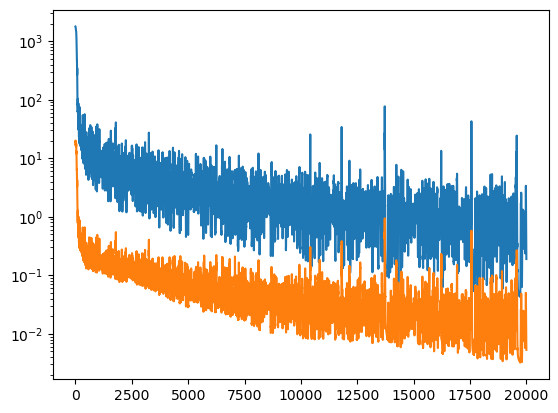

In [14]:
plt.plot(losses[:,0])
plt.plot(losses[:,1])
plt.yscale('log')

In [16]:
np.min(np.sum(losses, axis=1))

0.04583249019924551

In [18]:
(u, u_xx, u_yy, u_t, v, v_xx, v_yy, v_t) = grads(pinn, data)

In [27]:
def to(arr):
    return arr.numpy().reshape(y_range.shape[0], x_range.shape[0])

actual_u_der = pattern.params["D_u"]*(pattern.c_xx[0,:, : , -1] + pattern.c_yy[0,:, : , -1]) - pattern.c_t[0,:, : , -1]
actual_v_der = pattern.params["D_v"]*(pattern.c_xx[1,:, : , -1] + pattern.c_yy[1,:, : , -1]) - pattern.c_t[1,:, : , -1]

u_der = pattern.params["D_u"]*( to(u_xx) + to(u_yy))# - to(u_t2)[-1, ...]
v_der = pattern.params["D_v"]*( to(v_xx)+ to(v_yy))# - to(v_t2)[-1, ...]
# X and Y are misoriented
u_der = u_der.T
v_der = v_der.T

u = pattern.c[0,:, : , -1]
v = pattern.c[1,:, : , -1]
f = u * u * v / (1.0 + kappa_u * u * u)
f_u =  rho_u * f - mu_u * u + sigma_u
f_v =  - rho_v * f + sigma_v

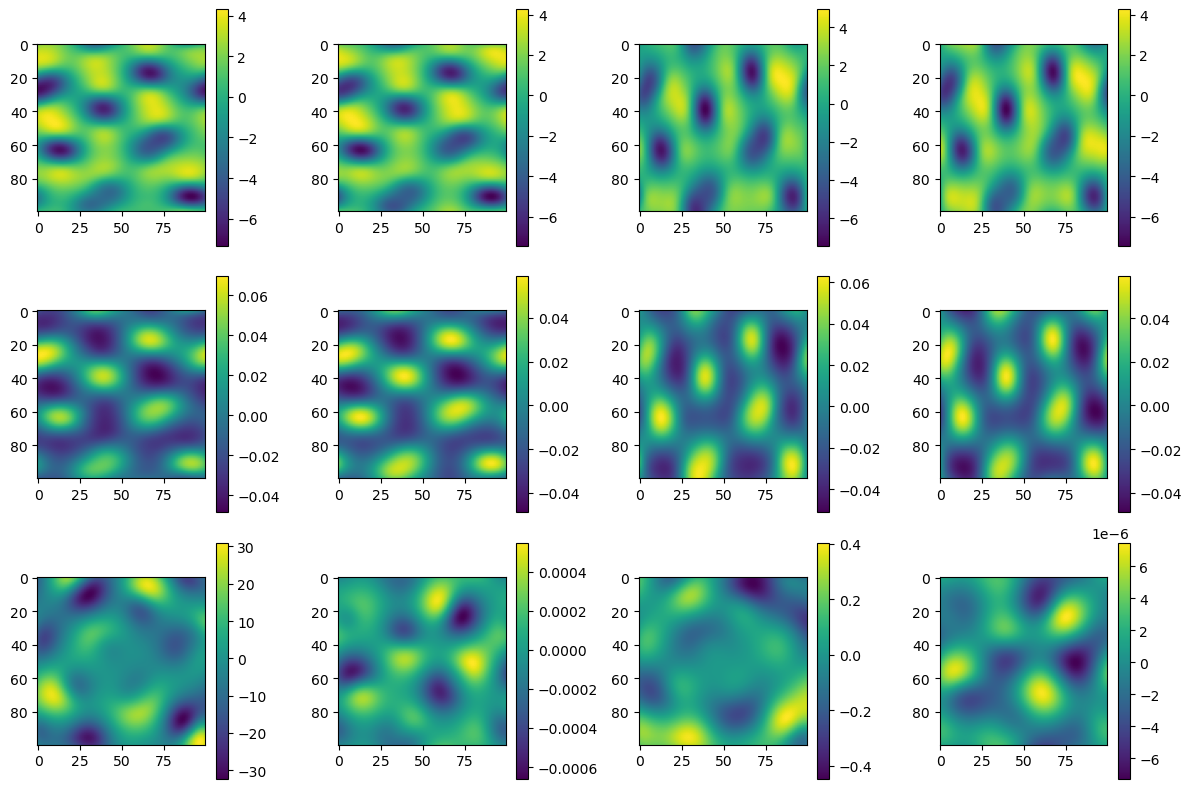

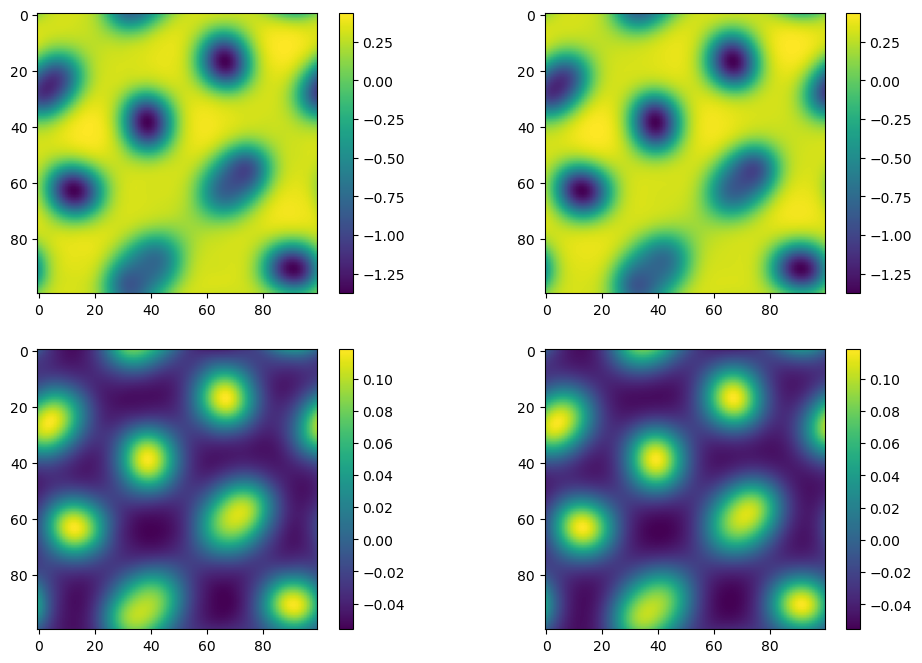

In [28]:


plt.figure(figsize=(12, 8))
plt.subplot(341)
plt.imshow(to(u_xx).T)
plt.colorbar()
plt.subplot(342)
plt.imshow(pattern.c_xx[0,:, : , -1])
plt.colorbar()
plt.subplot(343)
plt.imshow(to(u_yy).T)
plt.colorbar()
plt.subplot(344)
plt.imshow(pattern.c_yy[0,:, : , -1])
plt.colorbar()
plt.subplot(345)
plt.imshow(to(v_xx).T)
plt.colorbar()
plt.subplot(346)
plt.imshow(pattern.c_xx[1,:, : , -1])
plt.colorbar()
plt.subplot(347)
plt.imshow(to(v_yy).T)
plt.colorbar()
plt.subplot(3,4,8)
plt.imshow(pattern.c_yy[1,:, : , -1])
plt.colorbar()
plt.tight_layout()
plt.subplot(3,4,9)
plt.imshow(to(u_t))
plt.colorbar()
plt.subplot(3,4,10)
plt.imshow(pattern.c_t[0,:, : , -1])
plt.colorbar()
plt.subplot(3,4,11)
plt.imshow(to(v_t))
plt.colorbar()
plt.subplot(3,4,12)
plt.imshow(pattern.c_t[1,:, : , -1])
plt.colorbar()
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.imshow(u_der)
plt.colorbar()
plt.subplot(222)
plt.imshow(actual_u_der)
plt.colorbar()
plt.subplot(223)
plt.imshow(v_der)
plt.colorbar()
plt.subplot(224)
plt.imshow(actual_v_der)
plt.colorbar()

In [29]:
actual_u_der.shape

(100, 100)

In [30]:
def SE(ar1, ar2):
    return np.sum((ar1 - ar2)**2)
def RMSE(ar1, ar2):
    return np.sqrt(np.mean((ar1 - ar2)**2))
def RMSE_relative(ar1, ar2):
    return np.sqrt(np.mean((ar1/(ar2 + 1e-16) - 1)**2))
def max_diff(ar1, ar2):
    return np.max(np.abs(ar1 - ar2))

In [31]:
losses2[-1]

array([0.05133004, 0.0031442 ])

In [32]:
SE(f_u, -u_der)

0.042967856

In [33]:
SE(f_v, -v_der)

0.0030916783

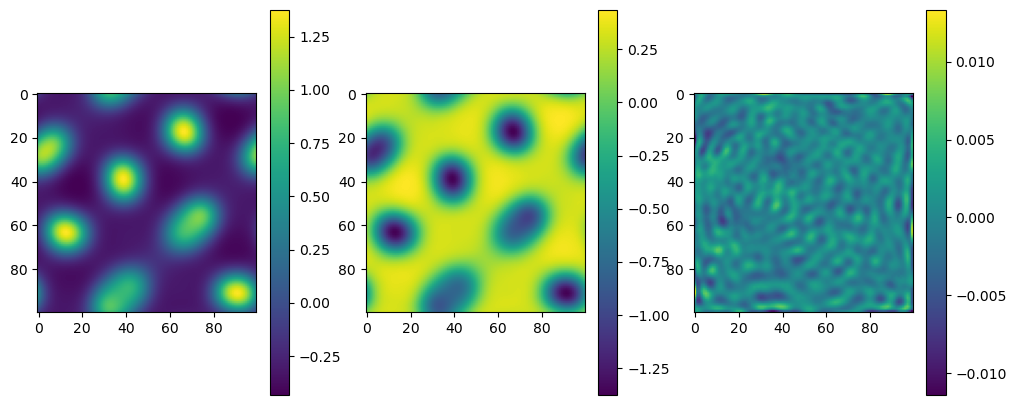

In [34]:
plt.figure(figsize=(12, 5))
plt.subplot(131)
plt.imshow(f_u)
plt.colorbar()
plt.subplot(132)
plt.imshow(u_der)
plt.colorbar()
plt.subplot(133)
plt.imshow(u_der+f_u)
plt.colorbar()

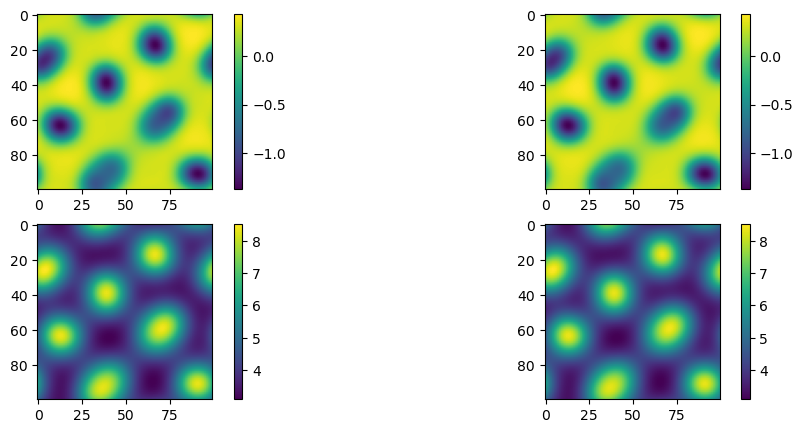

In [39]:

plt.figure(figsize=(12, 5))
plt.subplot(221)
plt.imshow(u_der)
plt.colorbar()
plt.subplot(222)
plt.imshow(actual_u_der)
plt.colorbar()
plt.subplot(223)
plt.imshow(u.reshape(100, 100))
plt.colorbar()
plt.subplot(224)
plt.imshow(pattern.c[0, :, :, -1])
plt.colorbar()
plt.show()


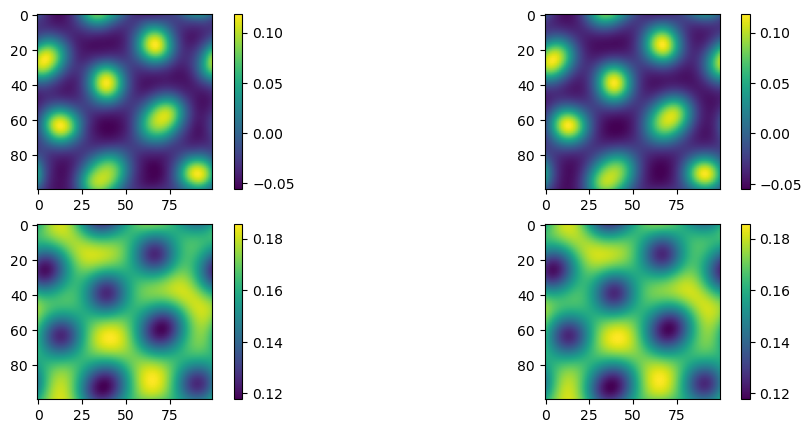

In [40]:

plt.figure(figsize=(12, 5))
plt.subplot(221)
plt.imshow(v_der)
plt.colorbar()
plt.subplot(222)
plt.imshow(actual_v_der)
plt.colorbar()
plt.subplot(223)
plt.imshow(v.reshape(100, 100))
plt.colorbar()
plt.subplot(224)
plt.imshow(pattern.c[1, :, :, -1])
plt.colorbar()
plt.show()

0.04296513678457051
0.002072803338104474
0.1704470891516975
0.013319454242274098


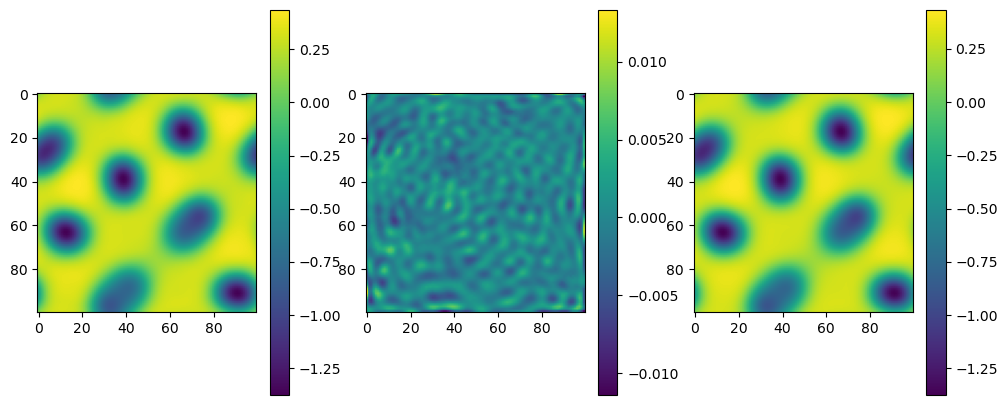

In [41]:

print(SE(u_der, actual_u_der))
print(RMSE(u_der, actual_u_der))
print(RMSE_relative(u_der, actual_u_der))
print(max_diff(u_der, actual_u_der))

plt.figure(figsize=(12, 5))
plt.subplot(131)
plt.imshow(u_der)
plt.colorbar()
plt.subplot(132)
plt.imshow(u_der-actual_u_der)
plt.colorbar()
plt.subplot(133)
plt.imshow(actual_u_der)
plt.colorbar()
plt.show()


0.0030916744151399628
0.0005560282740238991
0.5230166011731651
0.0030709024341939173


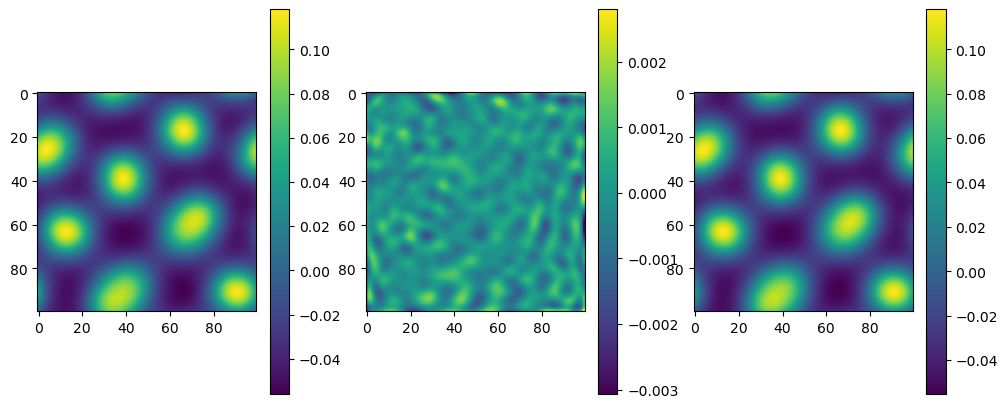

In [42]:
print(SE(v_der, actual_v_der))
print(RMSE(v_der, actual_v_der))
print(RMSE_relative(v_der, actual_v_der))
print(max_diff(v_der, actual_v_der))

plt.figure(figsize=(12, 5))
plt.subplot(131)
plt.imshow(v_der)
plt.colorbar()
plt.subplot(132)
plt.imshow(v_der-actual_v_der)
plt.colorbar()
plt.subplot(133)
plt.imshow(actual_v_der)
plt.colorbar()
plt.show()